In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from einops import rearrange, repeat,reduce
from einops.layers.torch import Rearrange
from torch import linalg as LA

In [3]:
import torch
import sys, os
import json
import torch.nn as nn  
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.optim as optim

# from torch.utils.tensorboard import SummaryWriter
import prettytable
import time, random
sys.setrecursionlimit(15000)
from thop.profile import profile

from PIL import Image
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchsummary import summary
from tqdm.notebook import tqdm
import seaborn as sns

from utils import ImageShow,draw_size_acc,one_hot,setup_seed
from utils import confusion_matrix,metrics_scores,pff

setup_seed(3047)

from model import CapsNet

In [4]:
# Settings.
sys.path.append(os.pardir)
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
img_title = "COVID_19"#"NCT_CRC"#"HAM_Matrix"# 
best_acc = 0.
eval_acc = 0.
best_train = 0.
dict_batch = {}
dict_imgSize = {}


try:
    print(len(train_acc_list))
except NameError:
    train_loss_list = []
    train_acc_list = []
    test_loss_list = []
    test_acc_list = []
    test_auc_list = []
    val_loss_list = []
    val_acc_list = []
#activate ImageShow
show = ImageShow(train_loss_list = train_loss_list,
                 train_acc_list = train_acc_list,
                test_loss_list = test_loss_list,
                test_acc_list = test_acc_list,
                test_auc_list = test_auc_list,
                val_loss_list = val_loss_list,
                val_acc_list = val_acc_list,
                )

In [5]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
# normalize = transforms.Normalize([0.5, 0.5, 0.5],[0.5, 0.5, 0.5])
Resize = transforms.Resize((225,300))

def get_data(trans='302'):
    global test_dataset,train_loader,val_loader,test_loader
    global train_num,val_num,test_num,n_classes,cla_dict
    vt = int(trans)
    data_transform = {
        "train": transforms.Compose([Resize,
                                     transforms.RandomVerticalFlip(),
                                     transforms.ToTensor(),
                                     normalize]),
        "val": transforms.Compose([Resize,
                                   transforms.ToTensor(),
                                   normalize]),
        "test": transforms.Compose([Resize,
                                    transforms.ToTensor(),
                                    normalize]),
        }

    data_root = os.path.abspath(os.path.join(os.getcwd(),".."))  # get data root path
    image_path = os.path.join(data_root, "datasets","COVID_19")#ham11,
    # image_path = os.path.join(data_root, "ImageNet")#
    assert os.path.exists(image_path), "{} path does not exist.".format(image_path)

    train_dataset = datasets.ImageFolder(root=os.path.join(image_path,train_doc),#
                                         transform=data_transform["train"])
    val_dataset = datasets.ImageFolder(root=os.path.join(image_path,val_doc),
                                            transform=data_transform["val"])
    test_dataset = datasets.ImageFolder(root=os.path.join(image_path,test_doc),
                                            transform=data_transform["test"])

    train_num = len(train_dataset)
    val_num = len(val_dataset)
    test_num = len(test_dataset)
    
    data_list = train_dataset.class_to_idx
    cla_dict = dict((val, key) for key, val in data_list.items())
    n_classes  = len(data_list)
    
    # write dict into json file
    json_str = json.dumps(cla_dict, indent=4)
    with open(f'{img_title}.json', 'w') as json_file:#class_indices
        json_file.write(json_str)
        
    pin_memory = True
    train_loader = DataLoader(train_dataset,batch_size=BatchSize,
                                               pin_memory=pin_memory,
                                               shuffle=True,num_workers=nw)
    val_loader = DataLoader(val_dataset,batch_size=V_size,
                                               pin_memory=pin_memory,
                                               shuffle=False,num_workers=nw)
    test_loader = DataLoader(test_dataset,batch_size=T_size,
                                              pin_memory=pin_memory,
                                              shuffle=False,num_workers=nw)

    print("using {} images for training, {} images for validation, {} images for testing.".format(train_num,
                                                                                                  val_num,
                                                                                                  test_num))

In [6]:
BatchSize = 168
V_size = 32
T_size = 32

sub_dirs = "orig"
train_doc = f"{sub_dirs}/train"
val_doc = f"{sub_dirs}/val" 
test_doc = f"{sub_dirs}/test" 

nw = 6#min([os.cpu_count(), BatchSize if BatchSize > 1 else 0, 6]) 
print(f'Using {nw} dataloader workers every process.')
get_data()
print(f'Using {n_classes} classes.')

Using 6 dataloader workers every process.
using 17146 images for training, 1906 images for validation, 2115 images for testing.
Using 4 classes.


In [7]:
# Code: https://github.com/Woodman718/FixCaps
n_channels = 3 #RGB
network = CapsNet(conv_inputs=n_channels,
                     num_classes=n_classes,# category_number                     
                     init_weights=True,)
network = network.to(device)

In [8]:
learning_rate = 0.123
optimizer = optim.Adam(network.parameters(), lr=learning_rate)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, 5, eta_min=1e-8, last_epoch=-1)

In [9]:
# img_size = 299
# summary(network,(n_channels,225,300))

In [10]:
network.Convolution

Sequential(
  (0): Conv2d(3, 128, kernel_size=(21, 21), stride=(2, 2))
  (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
)

In [11]:
dsize = (1, 3, 225, 300)
# mode='DS'
input_data = torch.randn(dsize).to(device)
pff(m_name="FixCaps",model=network,inputes=input_data)

  Model   | Params(M) | FLOPs(G) | FPS
----------|-----------|----------|-----
FixCaps |    1.41   |   2.74   | 104.6


In [12]:
def train(epoch):
    network.train()
    global best_train,train_evl_result#,evl_tmp_result
    running_loss,r_pre = 0., 0.
    print_step = len(train_loader)//2
    steps_num = len(train_loader)
    tmp_size = BatchSize
    print(f'\033[1;32m[Train Epoch:[{epoch}]{img_title} ==> Training]\033[0m ...')
    optimizer.zero_grad()
    train_tmp_result = torch.zeros(n_classes,n_classes)
    
    for batch_idx, (data, target) in enumerate(train_loader):        

        batch_idx += 1
        target_indices = target
        target_one_hot = one_hot(target, length=n_classes)
        data, target = Variable(data).to(device), Variable(target_one_hot).to(device)

        output = network(data)
        loss = network.loss(output, target, size_average=True)       
        loss.backward()     
        optimizer.step()
        optimizer.zero_grad()
        
        running_loss += loss.item()
 
        #v_mag = LA.norm(output,ord='fro',dim=(2,3), keepdim=True)#default:ord='fro'
        v_mag = LA.norm(output,ord='nuc',dim=(2,3), keepdim=True)#
        pred = v_mag.data.max(1, keepdim=True)[1].cpu().squeeze()
        r_pre += pred.eq(target_indices.view_as(pred)).squeeze().sum()
        tmp_pre = r_pre/(batch_idx*BatchSize)
        
        if batch_idx % print_step == 0 and batch_idx != steps_num:
            print("[{}/{}] Loss{:.5f},ACC:{:.5f}".format(batch_idx,len(train_loader),
                                                         loss,tmp_pre))
        if batch_idx % steps_num == 0 and train_num % tmp_size != 0:
            tmp_size = train_num % tmp_size
                          
        for i in range(tmp_size):
            pred_x = pred.numpy()
            train_tmp_result[target_indices[i]][pred_x[i]] +=1

        if best_train < tmp_pre and tmp_pre >= 90: 
            torch.save(network.state_dict(), iter_path)
        
    epoch_acc = r_pre / train_num
    epoch_loss = running_loss / len(train_loader)  
    train_loss_list.append(epoch_loss)
    train_acc_list.append(epoch_acc) 
    scheduler.step()
    if best_train < epoch_acc:
        best_train = epoch_acc
        train_evl_result = train_tmp_result.clone()
        torch.save(network.state_dict(), last_path)
        torch.save(train_evl_result, f'./tmp/{img_title}/{dirs}/train_evl_result.pth')
    
    print("Train Epoch:[{}] Loss:{:.5f},Acc:{:.5f},Best_train:{:.5f}".format(epoch,epoch_loss,
                                                                     epoch_acc,best_train))

In [13]:
def test(split="test"):
    network.eval()
    global test_acc,eval_acc,best_acc,net_parameters
    global test_evl_result,val_evl_result#,evl_tmp_result
    cor_loss,correct,Auc, Acc= 0, 0, 0, 0
    evl_tmp_result = torch.zeros(n_classes,n_classes)
    
    if split == 'val':
        data_loader = val_loader
        tmp_size = V_size
        data_num = val_num
    else:
        data_loader = test_loader
        tmp_size = T_size
        data_num = test_num
        
    steps_num = len(data_loader)
    print(f'\033[35m{img_title} ==> {split} ...\033[0m')
    
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(data_loader):
            batch_idx +=1
            target_indices = target#torch.Size([batch, 7])  
            target_one_hot = one_hot(target, length=n_classes)            
            data, target = Variable(data).to(device), Variable(target_one_hot).to(device)

            output= network(data)#torch.Size([batch_size, 7, 16, 1])         
            #v_mag = LA.norm(output,ord='fro',dim=(2,3), keepdim=True)#default:ord='fro'
            v_mag = LA.norm(output,ord='nuc',dim=(2,3), keepdim=True)#
            pred = v_mag.data.max(1, keepdim=True)[1].cpu()#[9, 2, 1, 1, 6,..., 1, 4, 6, 5, 7,]
            
            if batch_idx % steps_num == 0 and data_num % tmp_size != 0:
                tmp_size = data_num % tmp_size
                          
            for i in range(tmp_size):
                pred_y = pred.numpy()
                evl_tmp_result[target_indices[i]][pred_y[i]] +=1 

        diag_sum = torch.sum(evl_tmp_result.diagonal())
        all_sum = torch.sum(evl_tmp_result) 
        test_acc = 100. * float(torch.div(diag_sum,all_sum)) 
        print(f"{split}_Acc:\033[1;32m{round(float(test_acc),3)}%\033[0m")

        if split == 'val':
            val_acc_list.append(test_acc)
            if test_acc >= best_acc:
                best_acc = test_acc
                val_evl_result = evl_tmp_result.clone()#copy.deepcopy(input)
                torch.save(network.state_dict(), save_PATH)
                torch.save(val_evl_result, f'./tmp/{img_title}/{dirs}/best_evl_result.pth')
            print(f"Best_val:\033[1;32m[{round(float(best_acc),3)}%]\033[0m")
        else:
            test_acc_list.append(test_acc)
            if test_acc >= eval_acc:
                eval_acc = test_acc
                test_evl_result = evl_tmp_result.clone()#copy.deepcopy(input)
                torch.save(network.state_dict(), test_path)
                torch.save(test_evl_result, f'./tmp/{img_title}/{dirs}/{split}_evl_result.pth')
            print(f"Best_eval:\033[1;32m[{round(float(eval_acc),3)}%]\033[0m")
    

In [14]:
#create store
try:
    print(f"suf:{suf}")
except NameError:
    suf = time.strftime("%m%d_%H%M%S", time.localtime())
    dirs = suf + "_21_225N"
    print(f"suf:{suf}")   
if os.path.exists(f'./tmp/{img_title}/{dirs}'):
    print (f'Store: "./tmp/{img_title}/{dirs}"')
else:
    !mkdir -p ./tmp/{img_title}/{dirs}
iter_path = f'./tmp/{img_title}/{dirs}/train_{img_title}_{suf}.pth' #training
save_PATH = f'./tmp/{img_title}/{dirs}/best_{img_title}_{suf}.pth' #validation
last_path = f'./tmp/{img_title}/{dirs}/last_{img_title}_{suf}.pth' #training
test_path = f'./tmp/{img_title}/{dirs}/test_best_{img_title}_{suf}.pth' #testing
print(save_PATH)

suf:0326_000147
./tmp/COVID_19/0326_000147_21_225N/best_COVID_19_0326_000147.pth


In [15]:
num_epochs= 128

In [16]:
# network.load_state_dict(torch.load(last_path))
for epoch in range(1, num_epochs + 1): 
    train(epoch)
    test('val')
    
print('Finished Training')

[Train Epoch:[1]COVID_19 ==> Training] ...
[51/103] Loss0.32520,ACC:0.28000
[102/103] Loss0.24514,ACC:0.41054
Train Epoch:[1] Loss:0.35737,Acc:0.41059,Best_train:0.41059
COVID_19 ==> val ...
val_Acc:80.115%
Best_val:[80.115%]
[Train Epoch:[2]COVID_19 ==> Training] ...
[51/103] Loss0.25068,ACC:0.62815
[102/103] Loss0.18914,ACC:0.64589
Train Epoch:[2] Loss:0.23068,Acc:0.64592,Best_train:0.64592
COVID_19 ==> val ...
val_Acc:79.958%
Best_val:[80.115%]
[Train Epoch:[3]COVID_19 ==> Training] ...
[51/103] Loss0.18810,ACC:0.67180
[102/103] Loss0.18204,ACC:0.69141
Train Epoch:[3] Loss:0.20617,Acc:0.69159,Best_train:0.69159
COVID_19 ==> val ...
val_Acc:92.97%
Best_val:[92.97%]
[Train Epoch:[4]COVID_19 ==> Training] ...
[51/103] Loss0.18329,ACC:0.69643
[102/103] Loss0.18395,ACC:0.70670
Train Epoch:[4] Loss:0.19884,Acc:0.70670,Best_train:0.70670
COVID_19 ==> val ...
val_Acc:93.547%
Best_val:[93.547%]
[Train Epoch:[5]COVID_19 ==> Training] ...
[51/103] Loss0.18938,ACC:0.73424
[102/103] Loss0.17140,

In [17]:
show.conclusion(opt='val',img_title=img_title)

=================Conclusion====================
Dataset:[COVID_19]
Best_Epoch [119]
[Val] ACC:98.95%.


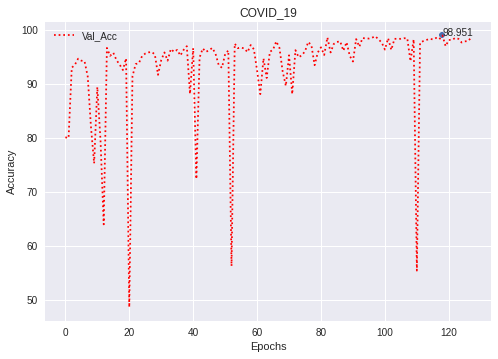

In [18]:
show.val(write=True,custom_path='./tmp',img_title=img_title,suf=dirs)

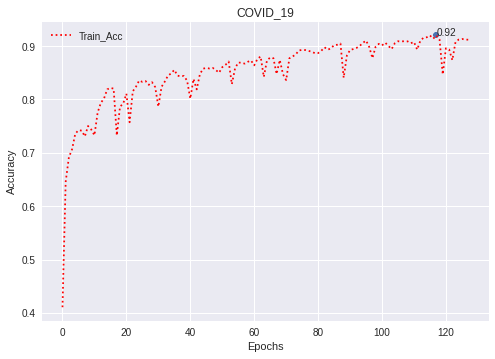

In [19]:
show.train(opt='Acc',write=True,custom_path='./tmp',img_title=img_title,suf=dirs)

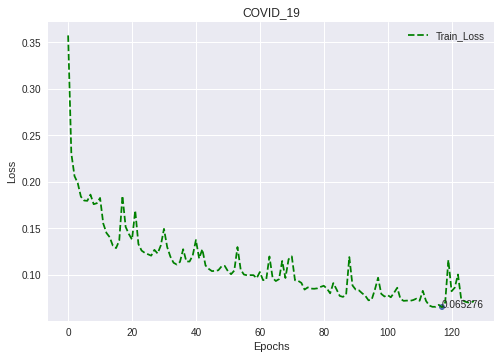

In [20]:
plt.clf()#clear photo
show.train(write=True,custom_path='./tmp',img_title=img_title,suf=dirs)

In [21]:
network.load_state_dict(torch.load(save_PATH))
 
dict_bat = {}
for k in range(8,65):#20--48
    T_size = k
    print(f"T_size:{k}")
    get_data()

    # for j in range(3):
    test()

    if dict_bat.get(k) is None or dict_bat[k] < test_acc:
            dict_bat[k] = test_acc

T_size:8
using 17146 images for training, 1906 images for validation, 2115 images for testing.
COVID_19 ==> test ...
test_Acc:97.541%
Best_eval:[97.541%]
T_size:9
using 17146 images for training, 1906 images for validation, 2115 images for testing.
COVID_19 ==> test ...
test_Acc:98.061%
Best_eval:[98.061%]
T_size:10
using 17146 images for training, 1906 images for validation, 2115 images for testing.
COVID_19 ==> test ...
test_Acc:98.392%
Best_eval:[98.392%]
T_size:11
using 17146 images for training, 1906 images for validation, 2115 images for testing.
COVID_19 ==> test ...
test_Acc:98.345%
Best_eval:[98.392%]
T_size:12
using 17146 images for training, 1906 images for validation, 2115 images for testing.
COVID_19 ==> test ...
test_Acc:98.676%
Best_eval:[98.676%]
T_size:13
using 17146 images for training, 1906 images for validation, 2115 images for testing.
COVID_19 ==> test ...
test_Acc:98.582%
Best_eval:[98.676%]
T_size:14
using 17146 images for training, 1906 images for validation, 2

In [22]:
show.conclusion(img_title=img_title)
print(sorted(dict_bat.items(), key=lambda x: x[1], reverse=True)[0:9])

=================Conclusion====================
Dataset:[COVID_19]
Best_Epoch [53]
[Test] ACC:99.72%.
[(60, 99.71631169319153), (15, 99.47990775108337), (22, 99.47990775108337), (27, 99.47990775108337), (30, 99.47990775108337), (45, 99.43262338638306), (20, 99.38534498214722), (19, 99.29078221321106), (43, 99.29078221321106)]


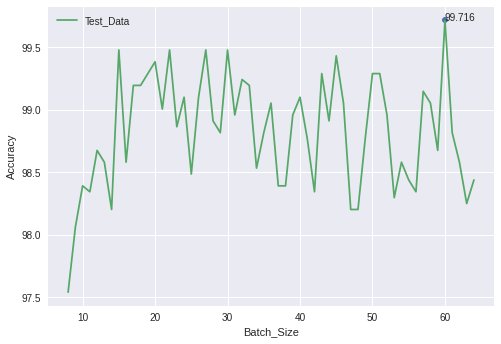

In [23]:
draw_size_acc(dict_bat,custom_path='./tmp',img_title=img_title,suf=dirs)

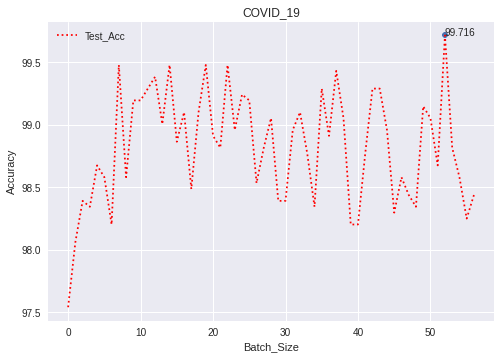

In [24]:
show.test(write=True,custom_path='./tmp',img_title=img_title,suf=dirs)

In [25]:
metrics_scores(test_evl_result,n_classes,cla_dict)

+---------+-----------+--------+--------+----------+
|   Type  | Precision | Recall |   F1   | Accuracy |
+---------+-----------+--------+--------+----------+
|  covid  |   0.9972  |  1.0   | 0.9986 |          |
|  normal |   0.999   | 0.9961 | 0.9975 |          |
| opacity |   0.995   | 0.9967 | 0.9958 |          |
|  viral  |   0.9926  |  1.0   | 0.9963 |          |
|  Total: |   0.996   | 0.9982 | 0.9971 |  0.9972  |
+---------+-----------+--------+--------+----------+


In [26]:
metrics_scores(val_evl_result,n_classes,cla_dict)

+---------+-----------+--------+--------+----------+
|   Type  | Precision | Recall |   F1   | Accuracy |
+---------+-----------+--------+--------+----------+
|  covid  |   0.9938  | 0.9938 | 0.9938 |          |
|  normal |   0.9945  | 0.9924 | 0.9934 |          |
| opacity |   0.9944  | 0.9797 | 0.987  |          |
|  viral  |   0.9248  |  1.0   | 0.9609 |          |
|  Total: |   0.9769  | 0.9915 | 0.9838 |  0.9895  |
+---------+-----------+--------+--------+----------+


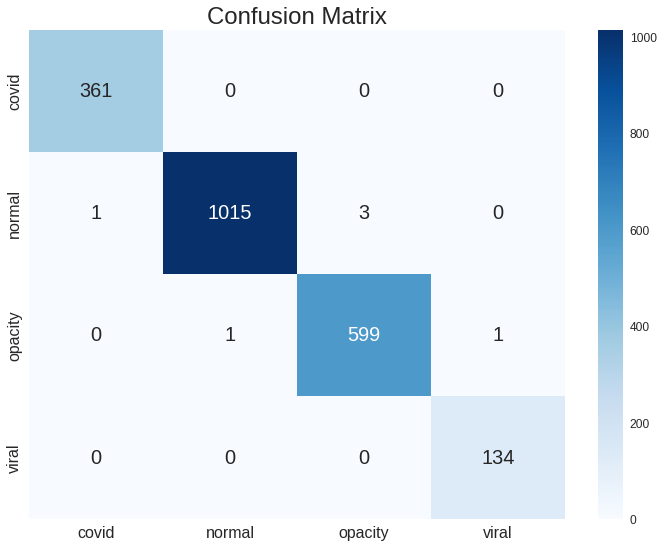

In [27]:
confusion_matrix(test_evl_result,n_classes,cla_dict,test_dataset,img_title=img_title,suf=dirs)

In [28]:
# #save
s0 = np.array(train_acc_list)
np.save(f'./tmp/{img_title}/{dirs}/{img_title}_train_acc_{suf}.npy', s0)
s1 = np.array(train_loss_list)
np.save(f'./tmp/{img_title}/{dirs}/{img_title}_train_loss_{suf}.npy', s1)
s2 = np.array(test_acc_list)
np.save(f'./tmp/{img_title}/{dirs}/{img_title}_test_acc_{suf}.npy', s2)
s3 = np.array(val_acc_list)
np.save(f'./tmp/{img_title}/{dirs}/{img_title}_val_acc_{suf}.npy', s2)
s4 = np.array(dict_batch)
np.save(f'./tmp/{img_title}/{dirs}/{img_title}_dict_batch_{suf}.npy', s2)

In [29]:
torch.cuda.memory.empty_cache()